# Task overview

In this exercise your goal will be to implement simple Transformer architecture "from scratch" (using only basic layers like nn.Embedding, nn.Linear, ReLU, softmax, einsum, etc.), train it on a toy problem, analyze results with and without some key components of Transformer, and visualize attention weights.

## Dataset

Dataset generation is already implemented below.

Each example is a sequence of tokens. Length of each sequence is 64 tokens, and each token is represented by a number 0 <= X < 16 (that is, we have a vocabulary of size 16).

For each token in the sequence your model should predict how many times this specific token occured in this sequence before or not. The label is a sequence of 64 numbers from 0 to 9 (inclusive), indicating the number of times the specific token appeared in the sequence. If a specific token appeared more than 9 times in the sequence before (this will be extremely rare) then the label is '9'.
You should use this dataset as a classification task, i.e. for each token output a probability for each of 10 possible labels.

For example, for sequence

[3 5 3 0 2 3 5 4 2 1 5 5]

the desired output is

[0 0 1 0 0 2 1 0 1 0 2 3] .

## Model implementation (1.5 points)

You should implement a *simplified* Transformer architecture with only the encoder. You can read the original paper introducing Transformer here for more details: https://arxiv.org/pdf/1706.03762.pdf 

The model will consist of:
* learnable, randomly initialized embeddings (you can just use nn.Embedding)
* positional encoding
* a number of encoding blocks, each consisting of
 * multi-head attention (wrapped in residual connection, see the image below)
 * feed-forward layer (wrapped in residual connection, see the image below)
* linear layer to get the output probabilities

Below you can see a version of Figure 1 from the paper representing this simplified model. Notice the lack of the right branch of the original model, including "Masked Multi-Head Attention". Notice also the lack of "Norm", which is LayerNorm used in the original model.

The general structure is already provided in the code. You have to implement those classes and functions:
* get_positional_encoding
* Attention
* FeedForward
* EncoderBlock

EncoderModel is already implemented. You can change it if you need it for visualizations etc.

## Model training (1 point)

The training loop is already implemented. In every step we generate a new training batch and train on it. You have to decide what model parameters to use, and what learning parameters to use.

Your model should achieve more than 80% accuracy on the test set (possibly much more), with accuracy defined as percentage of tokens classified correctly (token-level accuracy, not sequence-level accuracy).

Briefly discuss the training and achieved accuracy compared to your expectations. Discuss also in what situations your model makes mistakes.

## Experiments (1 point)

Train three additional models:
* one with positional encoding removed
* one with attention mechanism removed
* one with feed forward layer removed
* (optionally: one with both attention mechanism removed and positional encoding removed )

Those models *don't* have to achieve 80% accuracy.

Notice their accuracy on the test set and explain the difference (if any) between accuracy and training of those ablation models and the full model.

Produce sample predictions on examples from the test set with those ablation models and the main model. Briefly discuss those, e.g. what those models have learned, and why?

## Visualizations (0.5 points)

Make a simple visualization of attention weights of the main model. As an example, you can visualize for a given sequence, for a specific token, which other tokens it paid attention to with each attention head and/or each attention layer.

For those visualizations you can change the dataset (and retrain the model) to sequences of shorter size. Please keep the ratio of number of tokens to sequence length the same. E.g. you can use 8 tokens in sequences of length 32.

( Optionally: Do the same visualization also for the model without positional encoding. )

Briefly discuss those attention weights, especially compared to your expectations.

## Tips and tricks

* I recommend reading:
 * the original paper Attention is All You Need: https://arxiv.org/pdf/1706.03762.pdf
 * this blog-post explaining Transformer with illustrations: http://jalammar.github.io/illustrated-transformer/ 
* All models should train very quickly. If you use colab.research.google.com, and you have a GPU accelerator, then the model should definitely take less than 10 minutes reach 80% accuracy.
* About implementing multi-head attention:
 * I really recommend using torch.einsum . There are examples in https://numpy.org/doc/stable/reference/generated/numpy.einsum.html , in particular look at "Tensor contraction". This will especially help with reducing the number of reshapes/permutations/transpositions for matrix multiplications.
 * You can implement separate (parameterless) functions split_heads and merge_heads, which take a tensor and number of heads.
* About implementing positional encoding:
 * The original paper uses "sin" on even dimensions and "cos" on odd dimensions. However, the order doesn't matter - you can just as well generate "sin" and "cos" separately and concatenate them. If you look at "Illustrated Transformer" blog post above, you can see one graphic generated by concatenating sin/cos parts, and one graphic generated by interleaving sin/cos parts. Both methods work equally well, and concatenation is generally easier to implement.
* About general implementation:
 * If something is not working, check the output of each module separately.
 * If something is not working, check the output predictions of your model.

## Simplifications

If you find some parts of the task too hard you can do one of the following simplifications. Keep in mind that your score will be reduced appropriately; but this may enable you to proceed with experiments. Those techniques may also help you debug your model.
* If you have trouble training the model then try to generate a dataset with less tokens and smaller sequence length. It may be easier to spot a bug in your code then, or tune hyperparameters of the model.
* If you have trouble implementing positional encoding, then you could implement learnable positional encoding: that is, an additional nn.Embedding layer which takes a position of the token (instead of the token itself) and returns an embedding for this particular position.
* If you have trouble implementing multi-head attention, then you could implement just a single head attention, without any splitting and concatenation. (This may also help you to understand the method, and implement multi-head attention later.)

## Picture below:
The representation of simpplified model to be implemented. Compare it with Figure 1 in Attention is All You Need paper,  https://arxiv.org/pdf/1706.03762.pdf .


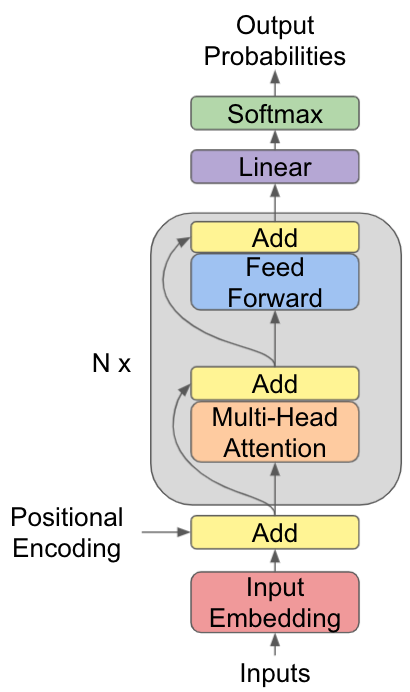

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device type', DEVICE)

device type cuda


In [2]:
MAX_COUNT = 9
OUTPUT_DIM = MAX_COUNT + 1

def get_single_example(n_tokens, seqlen):
  seq = np.random.randint(low=0, high=n_tokens, size=(seqlen,))
  label = [min(list(seq[:i]).count(seq[i]), MAX_COUNT) for i, x in enumerate(seq)]
  label = np.array(label)
  return seq, label

seq, label = get_single_example(n_tokens=16, seqlen=64)
print('Sequence:', seq)
print('Labels:', label)
print('Sequence and labels interleaved:\n', np.stack((seq, label)).transpose())

Sequence: [ 6  0  1 15  2  1 10 15  5  2  8  9  3 11  7 13 15 14 11  4  8 10  8  9
  8 11  9  8 14 15 12 10 10  3  7  5 10  0  9  4 11  2  8 15  5 13 14 14
 12 10  4  0  1  3 10 15  2  7  2  0  7  0  6 14]
Labels: [0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 2 0 1 0 1 1 2 1 3 2 2 4 1 3 0 2 3 1 1 1 4
 1 3 1 3 2 5 4 2 1 2 3 1 5 2 2 2 2 6 5 3 2 4 3 3 4 1 4]
Sequence and labels interleaved:
 [[ 6  0]
 [ 0  0]
 [ 1  0]
 [15  0]
 [ 2  0]
 [ 1  1]
 [10  0]
 [15  1]
 [ 5  0]
 [ 2  1]
 [ 8  0]
 [ 9  0]
 [ 3  0]
 [11  0]
 [ 7  0]
 [13  0]
 [15  2]
 [14  0]
 [11  1]
 [ 4  0]
 [ 8  1]
 [10  1]
 [ 8  2]
 [ 9  1]
 [ 8  3]
 [11  2]
 [ 9  2]
 [ 8  4]
 [14  1]
 [15  3]
 [12  0]
 [10  2]
 [10  3]
 [ 3  1]
 [ 7  1]
 [ 5  1]
 [10  4]
 [ 0  1]
 [ 9  3]
 [ 4  1]
 [11  3]
 [ 2  2]
 [ 8  5]
 [15  4]
 [ 5  2]
 [13  1]
 [14  2]
 [14  3]
 [12  1]
 [10  5]
 [ 4  2]
 [ 0  2]
 [ 1  2]
 [ 3  2]
 [10  6]
 [15  5]
 [ 2  3]
 [ 7  2]
 [ 2  4]
 [ 0  3]
 [ 7  3]
 [ 0  4]
 [ 6  1]
 [14  4]]


In [3]:
import math
import torch.nn.functional as F

class Attention(nn.Module):
  def __init__(self, hidden_dim, num_heads):
    super(Attention, self).__init__()

    self.k_dim = hidden_dim // num_heads # k_dim == v_dim
    self.root_k_dim = math.sqrt(self.k_dim)
    self.num_heads = num_heads
    self.linears = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(4)])
    self.attention = None

  def __attention(self, query, key, value):
    scores = torch.matmul(query, key.transpose(-2, -1))
    att_weights = F.softmax(scores / self.root_k_dim, dim=-1)

    return torch.matmul(att_weights, value), att_weights

  def forward(self, x):
    # x shape: (seqlen, batch, hiddendim)
    n_batches = x.shape[1]
    matrices = [l(x).view(-1, n_batches, self.num_heads, self.k_dim).transpose(0,2) for l in self.linears[:-1]]

    x, att_weights = self.__attention(*matrices)
    x = x.transpose(0, 2).contiguous().view(-1, n_batches, self.num_heads * self.k_dim)
    result = self.linears[-1](x)

    return result, att_weights

class FeedForward(nn.Module):
  def __init__(self, hidden_dim, d_ff):
    super(FeedForward, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(hidden_dim, d_ff),
        nn.ReLU(),
        nn.Linear(d_ff, hidden_dim)
    )

  def forward(self, x):
    # x shape: (seqlen, batch, hiddendim)

    return self.layers(x)

class EncoderLayer(nn.Module):
  def __init__(self, hidden_dim, d_ff, num_heads, use_attention=True,
               use_feedforward=True):
    super(EncoderLayer, self).__init__()
    self.attention = Attention(hidden_dim, num_heads) if use_attention else None
    self.feed_forward = FeedForward(hidden_dim, d_ff) if use_feedforward else None


  def forward(self, x):
    # x shape: (seqlen, batch, hiddendim)
    result, att_weights = x, None

    if self.attention:
      res_att, att_weights = self.attention(result)
      result = result + res_att
    
    if self.feed_forward:
      result = result + self.feed_forward(result)

    return result, att_weights

def get_positional_encoding(n_positions, n_dimensions):
  positional_encoding = torch.zeros(n_positions, n_dimensions, dtype=torch.float, device=DEVICE)

  position = torch.arange(0, n_positions).unsqueeze(1)
  div_term = torch.exp(torch.arange(0, n_dimensions, 2) * -(math.log(10000.0) / n_dimensions))

  positional_encoding[:, 0::2] = torch.sin(position * div_term)
  positional_encoding[:, 1::2] = torch.cos(position * div_term)

  # output shape: (seqlen, hiddendim)
  return positional_encoding

class EncoderModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, d_ff, output_dim, n_layers,
               num_heads, use_attention=True, use_feedforward=True,
               use_positional=True):
    super(EncoderModel, self).__init__()
    
    self._use_positional = use_positional
    self.embedding_layer = nn.Embedding(input_dim, hidden_dim)
    self.layers = nn.ModuleList([
          EncoderLayer(hidden_dim, d_ff, num_heads, use_attention,
                       use_feedforward) for i in range(n_layers)])
    self.output_layer = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, return_att_weights=False):
    # x shape: (seqlen, batch)
    hidden = self.embedding_layer(x)
    # hidden shape: (seqlen, batch, hiddendim)

    if self._use_positional:
      positional_encoding = get_positional_encoding(
          n_positions=hidden.shape[0], n_dimensions=hidden.shape[-1])
      # reshaping to (seqlen, 1, hiddendim)
      positional_encoding = torch.reshape(
          positional_encoding, (hidden.shape[0], 1, hidden.shape[-1]))
      hidden = hidden + positional_encoding
    
    list_att_weights = []
    for layer in self.layers:
      hidden, att_weights = layer(hidden)
      list_att_weights.append(att_weights)
    
    result = self.output_layer(hidden)

    if return_att_weights:
      return result, list_att_weights
    else:
      return result

## This is training loop and test set generation.

In [4]:
def gen_dataset(dataset_size, n_tokens, seqlen):
  dataset = [get_single_example(n_tokens, seqlen) for i in range(dataset_size)]
  
  # Transpositions are used, because the convention in PyTorch is to represent
  # sequence tensors as <seq_len, batch_size> instead of <batch_size, seq_len>.
  X = torch.tensor([x[0] for x in dataset],
                        device=DEVICE).transpose(0, 1)
  Y = torch.tensor([x[1] for x in dataset],
                        device=DEVICE).transpose(0, 1)

  return X, Y

In [220]:
def train_model(model, lr, num_steps, batch_size, n_tokens, seqlen, test_X, test_Y, get_errs=False, print_mismatched=False):
  model.to(DEVICE)

  start_time = time()
  accs = []
  errs = []
  
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for step in range(num_steps):  
    batch_X, batch_Y = gen_dataset(batch_size, n_tokens, seqlen)

    model.train()
    model.zero_grad()
    logits = model(batch_X)
    loss = loss_function(logits.reshape(-1, OUTPUT_DIM), batch_Y.reshape(-1))
    loss.backward()
    optimizer.step()
    


    if step % (num_steps//100) == 0 or step == num_steps - 1:
      # Printing a summary of the current state of training every 1% of steps.
      model.eval()
      predicted_logits = model.forward(test_X).reshape(-1, OUTPUT_DIM)
      predicted_tokens = torch.argmax(predicted_logits, dim=-1)

      test_acc = (
          torch.sum(predicted_tokens == test_Y.reshape(-1))
          / test_Y.reshape(-1).shape[0])
      print('step', step, 'out of', num_steps)
      print('loss train', float(loss))
      print('accuracy test', float(test_acc))
        
      if get_errs:
          err = predicted_tokens.view(test_Y.shape) - test_Y
          for i, row in enumerate(err):
            for e in row:
                n = e.item()
                if n:
                    errs.append([i, n])
    
      if print_mismatched:
          mismatched = torch.nonzero(torch.all(torch.eq(predicted_tokens.view(test_Y.shape), test_Y), dim=0) == False)
          if not mismatched.shape[0]:
                break
          mismatched_indices = mismatched.squeeze(-1)[torch.randint(0, mismatched.shape[0], (1,))]
          print("Mismatch example:")
          for i in mismatched_indices:
              print("Sequence: ", test_X[:,i].cpu().numpy())
              print("Predicted: ", predicted_tokens.view(test_Y.shape)[:,i].cpu().numpy())
              print("Ground truth: ", test_Y[:,i].cpu().numpy())      

      print()
      accs.append(test_acc)
        
  print('\nTRAINING TIME:', time()-start_time)
  model.eval()
    
  return accs, errs

In [221]:
def plot_errs(num_steps, seq_len, errs):
    df = pd.DataFrame(errs, columns=['pos', 'err']).groupby(['pos', 'err']).size().reset_index(name='counts')

    fig, ax = plt.subplots(figsize=(20,5), dpi=80)
    ax.grid(color='lightgray', linestyle='dashed', linewidth=.1)
    ax.scatter(x=df.pos, y=df.err, c=df.counts, s=df.counts*.05, cmap='plasma')
    ax.set_xticks(range(0, seq_len))
    ax.set_yticks(range(-9, 10))
    ax.set_xlabel("Position")
    ax.set_ylabel("Absolute error")
    plt.show()

In [222]:
def plot_accs(num_steps, accs):
    plt.plot([i * num_steps/(len(accs)-1) for i in range(len(accs))], accs)
    plt.xlabel('Steps')
    plt.ylabel('Test Acc')
    plt.show()

## This is example training.

Test your models and visualize attention weights.

In [239]:
np.set_printoptions(linewidth=240)

TEST_SET = gen_dataset(TEST_SIZE, N_TOKENS, SEQ_LEN)

HIDDEN_DIM = 512 
FF_DIM = 2048 
N_HEADS = 8 
N_LAYERS = 6  

BATCH_SIZE = 64  
LR = 0.00005  
NUM_STEPS = 2000

TEST_SIZE = 128
N_TOKENS = 16
SEQ_LEN = 64

step 0 out of 2000
loss train 3.004598617553711
accuracy test 0.2362060546875

step 20 out of 2000
loss train 1.5987788438796997
accuracy test 0.3515625

step 40 out of 2000
loss train 1.5227971076965332
accuracy test 0.3582763671875

step 60 out of 2000
loss train 1.518210768699646
accuracy test 0.365478515625

step 80 out of 2000
loss train 1.471741795539856
accuracy test 0.377685546875

step 100 out of 2000
loss train 1.443289875984192
accuracy test 0.3973388671875

step 120 out of 2000
loss train 1.3329601287841797
accuracy test 0.4786376953125

step 140 out of 2000
loss train 1.1136064529418945
accuracy test 0.553466796875

step 160 out of 2000
loss train 0.8912485837936401
accuracy test 0.6009521484375

step 180 out of 2000
loss train 0.7845683097839355
accuracy test 0.680419921875

step 200 out of 2000
loss train 0.6761471033096313
accuracy test 0.7265625

step 220 out of 2000
loss train 0.6558195352554321
accuracy test 0.7142333984375

step 240 out of 2000
loss train 0.50990599

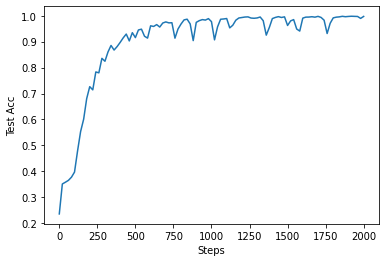

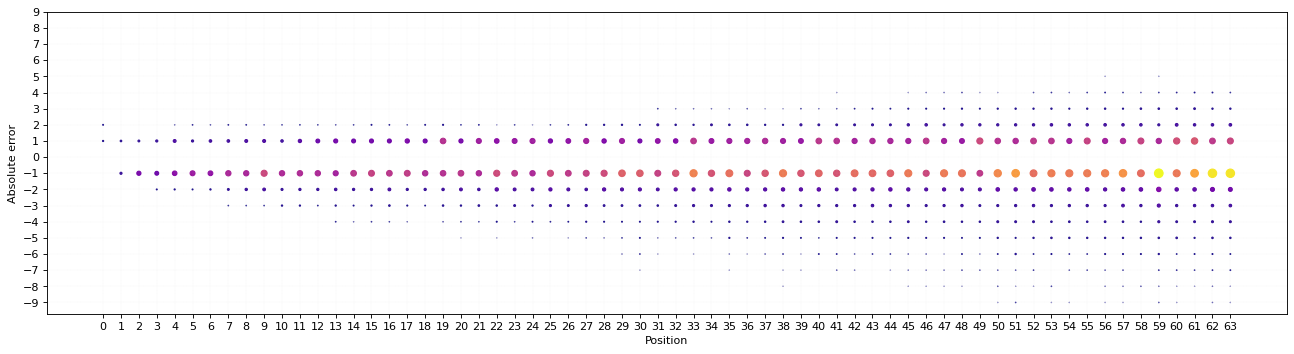

In [240]:
model = EncoderModel(N_TOKENS, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, N_HEADS)
accs, errs = train_model(model, LR, NUM_STEPS, BATCH_SIZE, N_TOKENS, SEQ_LEN, *TEST_SET, get_errs=True)
plot_accs(NUM_STEPS, accs)
plot_errs(NUM_STEPS, SEQ_LEN, errs)

#### Conclusions

The hyperparamters were mostly copied from the "Attention is all you need" paper and after tweaking the learning rate resulted in an almost perfect accuracy of 99.6%.
Looking at the distribution of the aboslute errors, it can be concluded that the model has, as one could expect, a tendecy to make considerably more mistakes at the later positions of the sequence. 
Besides, it is prone to understating the values rather than overstating them.


step 0 out of 2000
loss train 2.5786051750183105
accuracy test 0.2259521484375

step 20 out of 2000
loss train 1.86652672290802
accuracy test 0.23681640625

step 40 out of 2000
loss train 1.841020941734314
accuracy test 0.2459716796875

step 60 out of 2000
loss train 1.810497760772705
accuracy test 0.244140625

step 80 out of 2000
loss train 1.771209716796875
accuracy test 0.2459716796875

step 100 out of 2000
loss train 1.7236709594726562
accuracy test 0.2459716796875

step 120 out of 2000
loss train 1.7026153802871704
accuracy test 0.2459716796875

step 140 out of 2000
loss train 1.647985577583313
accuracy test 0.2459716796875

step 160 out of 2000
loss train 1.6339445114135742
accuracy test 0.2459716796875

step 180 out of 2000
loss train 1.6004307270050049
accuracy test 0.2459716796875

step 200 out of 2000
loss train 1.5942554473876953
accuracy test 0.2459716796875

step 220 out of 2000
loss train 1.5856292247772217
accuracy test 0.2459716796875

step 240 out of 2000
loss train 1.

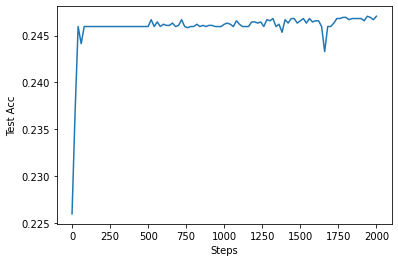

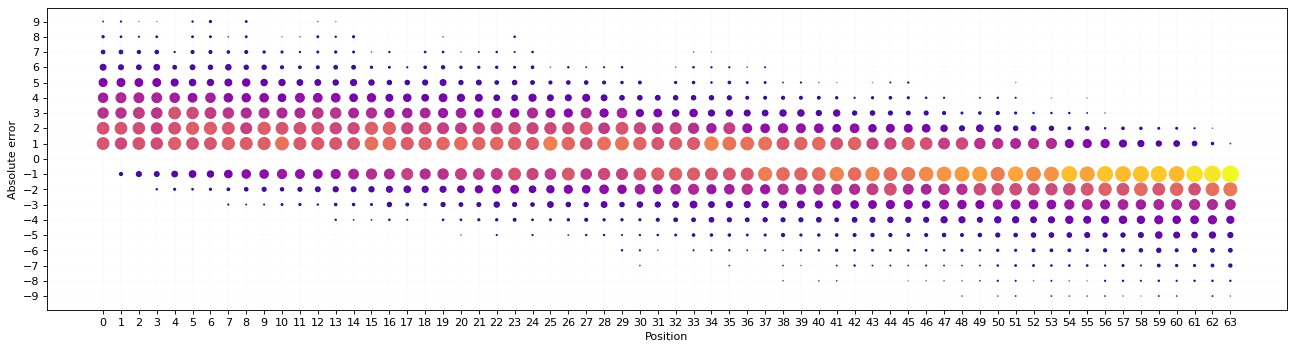

In [241]:
# Positional encoding removed
model = EncoderModel(N_TOKENS, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, N_HEADS, use_positional=False)
accs, errs = train_model(model, LR, NUM_STEPS, BATCH_SIZE, N_TOKENS, SEQ_LEN, *TEST_SET, get_errs=True)
plot_accs(NUM_STEPS, accs)
plot_errs(NUM_STEPS, SEQ_LEN, errs)

#### Conclusions

With positional encodings removed, the model seems to make somewhat random guesses and unable to learn anything worthwile.

step 0 out of 2000
loss train 2.796851873397827
accuracy test 0.2177734375

step 20 out of 2000
loss train 1.565529704093933
accuracy test 0.3472900390625

step 40 out of 2000
loss train 1.559066653251648
accuracy test 0.3597412109375

step 60 out of 2000
loss train 1.4827971458435059
accuracy test 0.3546142578125

step 80 out of 2000
loss train 1.4956632852554321
accuracy test 0.35791015625

step 100 out of 2000
loss train 1.5265984535217285
accuracy test 0.3546142578125

step 120 out of 2000
loss train 1.5191823244094849
accuracy test 0.3553466796875

step 140 out of 2000
loss train 1.5452083349227905
accuracy test 0.3568115234375

step 160 out of 2000
loss train 1.5194813013076782
accuracy test 0.35888671875

step 180 out of 2000
loss train 1.490073800086975
accuracy test 0.357666015625

step 200 out of 2000
loss train 1.496126413345337
accuracy test 0.3546142578125

step 220 out of 2000
loss train 1.520202875137329
accuracy test 0.3531494140625

step 240 out of 2000
loss train 1.50

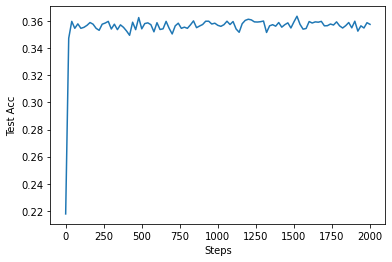

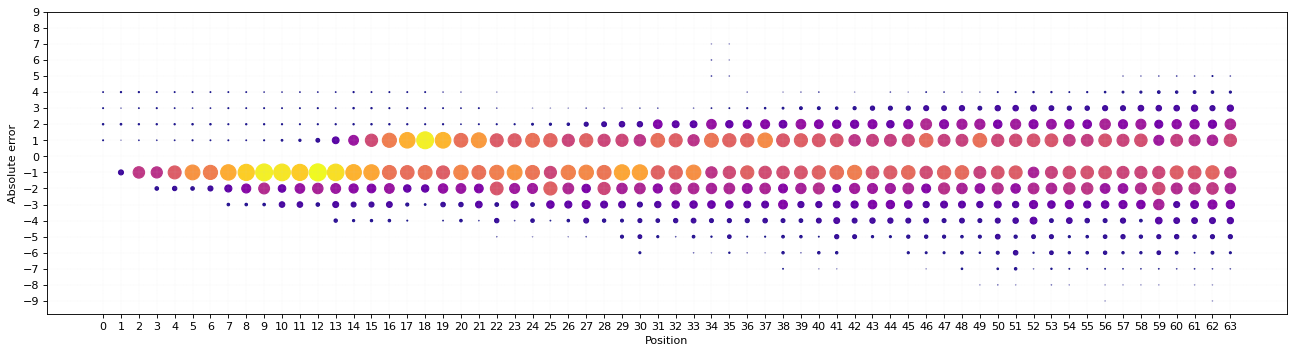

In [242]:
# Attention removed
model = EncoderModel(N_TOKENS, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, N_HEADS, use_attention=False)
accs, errs = train_model(model, LR, NUM_STEPS, BATCH_SIZE, N_TOKENS, SEQ_LEN, *TEST_SET, get_errs=True)
plot_accs(NUM_STEPS, accs)
plot_errs(NUM_STEPS, SEQ_LEN, errs)

#### Conclusion

The model does considerably better without the attention layer than without positional encodings, although it is still unable to learn. Judging by the error distribution the model is able to predict higher values for higher positions, but is unaware of the preceding tokens.

step 0 out of 2000
loss train 2.4027416706085205
accuracy test 0.2225341796875

step 20 out of 2000
loss train 1.7506271600723267
accuracy test 0.3345947265625

step 40 out of 2000
loss train 1.573992133140564
accuracy test 0.35400390625

step 60 out of 2000
loss train 1.528885006904602
accuracy test 0.36474609375

step 80 out of 2000
loss train 1.5060474872589111
accuracy test 0.377197265625

step 100 out of 2000
loss train 1.433168888092041
accuracy test 0.401123046875

step 120 out of 2000
loss train 1.2976504564285278
accuracy test 0.471923828125

step 140 out of 2000
loss train 1.1170213222503662
accuracy test 0.5179443359375

step 160 out of 2000
loss train 0.9796535968780518
accuracy test 0.59375

step 180 out of 2000
loss train 0.8937968611717224
accuracy test 0.633544921875

step 200 out of 2000
loss train 0.7756155133247375
accuracy test 0.661376953125

step 220 out of 2000
loss train 0.7529205083847046
accuracy test 0.7022705078125

step 240 out of 2000
loss train 0.63823962

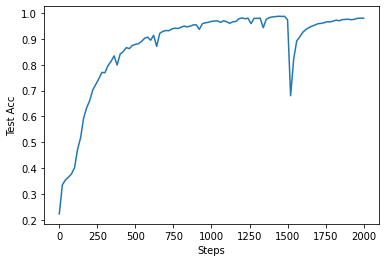

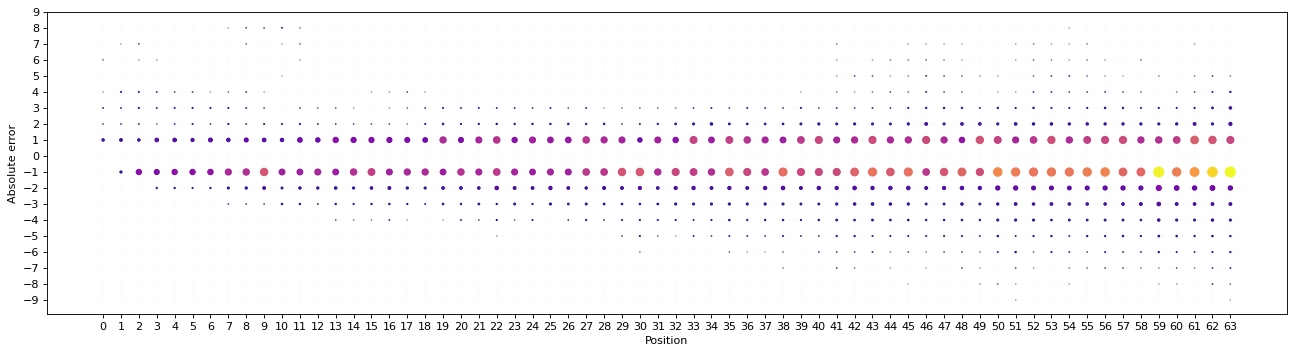

In [243]:
# Feedforward removed
model = EncoderModel(N_TOKENS, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, N_HEADS, use_feedforward=False)
accs, errs = train_model(model, LR, NUM_STEPS, BATCH_SIZE, N_TOKENS, SEQ_LEN, *TEST_SET, get_errs=True)
plot_accs(NUM_STEPS, accs)
plot_errs(NUM_STEPS, SEQ_LEN, errs)

#### Conslusion

Surprisingly, removing the feedforward layer only reduced the overall accuracy by ~1 percent point. The absolute errors are more evenly distributed compared to the full model's.

## Visualisations

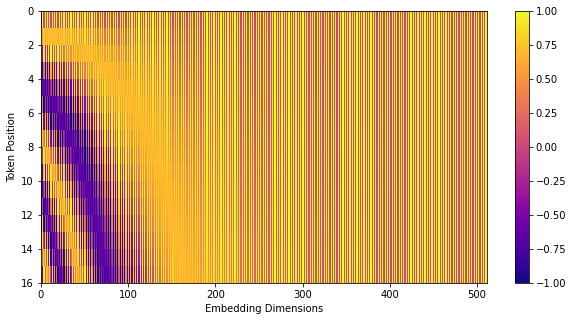

In [234]:
# Visualising positional encodings

pos_encoding = get_positional_encoding(N_TOKENS, HIDDEN_DIM)

plt.figure(figsize=(10,5))
plt.pcolormesh(pos_encoding.clone().cpu().detach().numpy(), cmap='plasma')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, HIDDEN_DIM))
plt.ylim((N_TOKENS,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

In [231]:
import seaborn as sns
import random

def visualise_attention(model, data):
  model.eval()
  _, att_weights = model.forward(data, return_att_weights=True)

  elem = random.randint(0, data.shape[1])
  seq = data[:,elem].cpu().detach().numpy()
  for l, att_w in enumerate(att_weights):
    print("Attention layer ", l + 1)

    heads = att_w.shape[0]
    fig, axs = plt.subplots(1, heads, figsize=(20, 10))
    for h in range(heads):
      sns.heatmap(att_w[h, elem, :, :].cpu().detach().numpy(), xticklabels=seq, yticklabels=seq, square=True, cbar=False, ax=axs[h])
    plt.show()

step 0 out of 2000
loss train 2.685121536254883
accuracy test 0.06982421875
Mismatch example:
Sequence:  [3 2 0 2 3 1 0 2 2 1 0 1 0 3 1 3]
Predicted:  [6 7 9 9 6 0 9 6 6 0 9 0 9 6 0 6]
Ground truth:  [0 0 0 1 1 0 1 2 3 1 2 2 3 2 3 3]

step 20 out of 2000
loss train 2.2971320152282715
accuracy test 0.15087890625
Mismatch example:
Sequence:  [1 0 0 1 2 3 3 2 2 3 0 1 2 1 1 1]
Predicted:  [0 9 9 0 1 6 6 1 2 6 9 0 1 0 0 0]
Ground truth:  [0 0 1 1 0 0 1 1 2 2 2 2 3 3 4 5]

step 40 out of 2000
loss train 2.108752727508545
accuracy test 0.228515625
Mismatch example:
Sequence:  [2 3 0 2 3 3 0 1 2 2 0 0 1 1 2 2]
Predicted:  [3 1 9 1 1 1 9 0 2 2 1 1 0 0 2 2]
Ground truth:  [0 0 0 1 1 2 1 0 2 3 2 3 1 2 4 5]

step 60 out of 2000
loss train 1.945081114768982
accuracy test 0.25830078125
Mismatch example:
Sequence:  [2 3 2 0 3 3 0 2 2 2 1 0 1 1 3 1]
Predicted:  [3 1 1 1 1 1 1 2 2 2 0 1 0 0 1 0]
Ground truth:  [0 0 1 0 1 2 1 2 3 4 0 2 1 2 3 3]

step 80 out of 2000
loss train 1.8797343969345093
accuracy

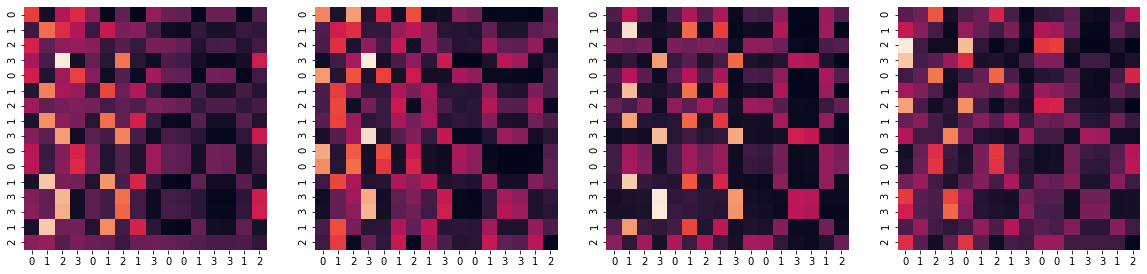

Attention layer  2


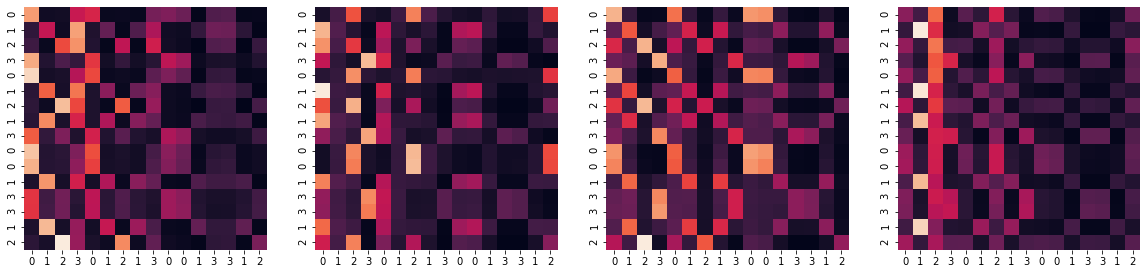

Attention layer  3


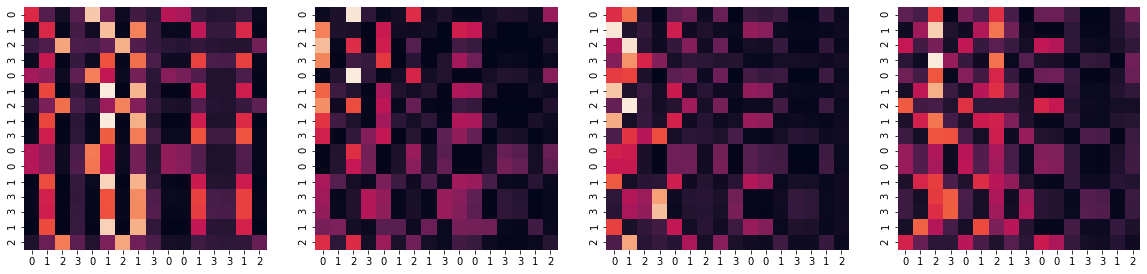

Attention layer  4


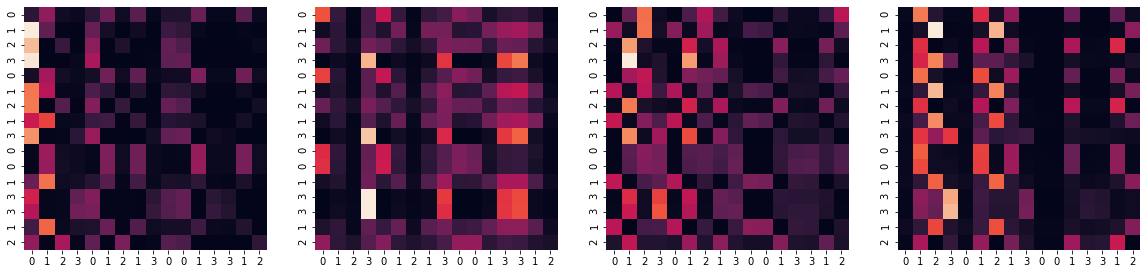

Attention layer  5


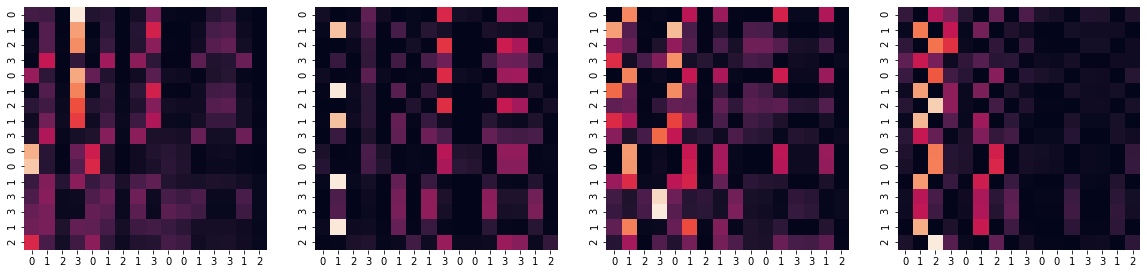

Attention layer  6


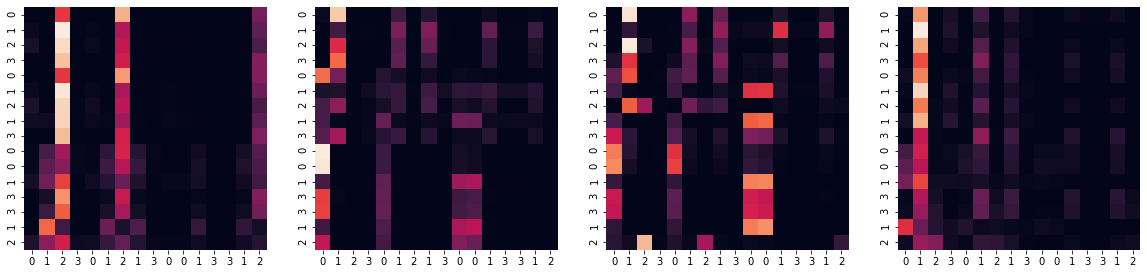

In [237]:
# Attention visualisation
vis_n_tokens = 4
vis_seq_len = 16

vis_test_X, vis_test_Y = gen_dataset(TEST_SIZE, vis_n_tokens, vis_seq_len)

# Retraining the model for shorter sequences
model = EncoderModel(vis_n_tokens, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, 4)
_ = train_model(model, LR / 100, NUM_STEPS, BATCH_SIZE, vis_n_tokens, vis_seq_len, vis_test_X, vis_test_Y, print_mismatched=True, get_errs=False)

visualise_attention(model, vis_test_X)

step 0 out of 2000
loss train 2.424483299255371
accuracy test 0.181640625
Mismatch example:
Sequence:  [1 3 1 0 2 1 1 0 2 0 0 2 3 0 3 1]
Predicted:  [2 2 2 2 5 2 2 2 5 2 2 5 2 2 2 2]
Ground truth:  [0 0 1 0 0 2 3 1 1 2 3 2 1 4 2 4]

step 20 out of 2000
loss train 2.1957900524139404
accuracy test 0.21484375
Mismatch example:
Sequence:  [2 2 3 1 1 3 1 3 0 0 1 2 1 3 3 2]
Predicted:  [0 0 2 2 2 2 2 2 2 2 2 0 2 2 2 0]
Ground truth:  [0 1 0 0 1 1 2 2 0 1 3 2 4 3 4 3]

step 40 out of 2000
loss train 2.0402305126190186
accuracy test 0.2197265625
Mismatch example:
Sequence:  [2 3 2 1 2 2 0 3 0 0 2 1 2 3 2 0]
Predicted:  [0 2 0 1 0 0 2 2 2 2 0 1 0 2 0 2]
Ground truth:  [0 0 1 0 2 3 0 1 1 2 4 1 5 2 6 3]

step 60 out of 2000
loss train 1.9358601570129395
accuracy test 0.23095703125
Mismatch example:
Sequence:  [1 1 0 0 2 1 0 3 0 3 1 3 2 2 0 3]
Predicted:  [1 1 0 0 0 1 0 2 0 2 1 2 0 0 0 2]
Ground truth:  [0 1 0 1 0 2 2 0 3 1 3 2 1 2 4 3]

step 80 out of 2000
loss train 1.900876760482788
accuracy te

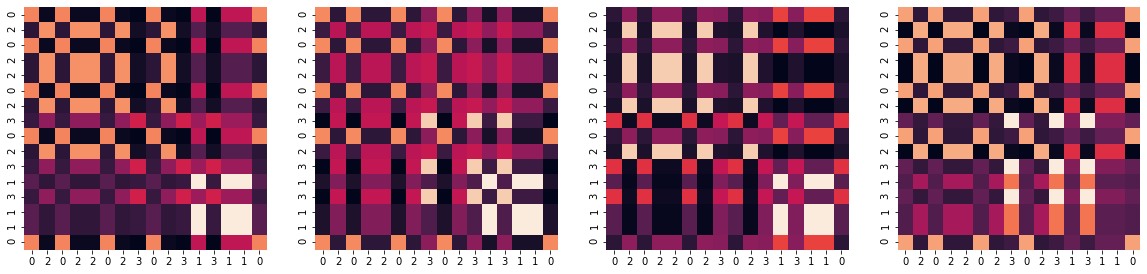

Attention layer  2


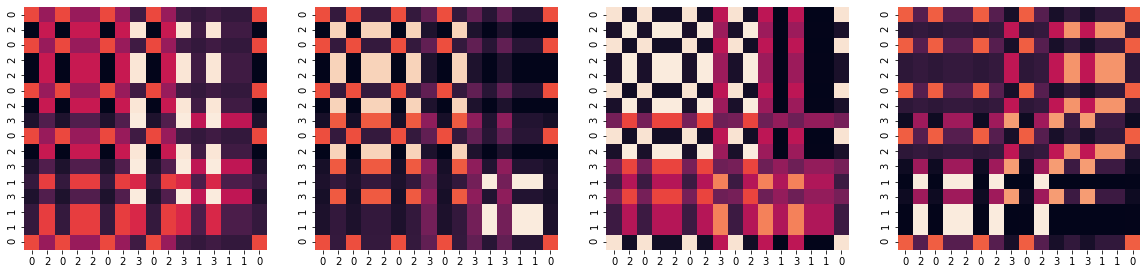

Attention layer  3


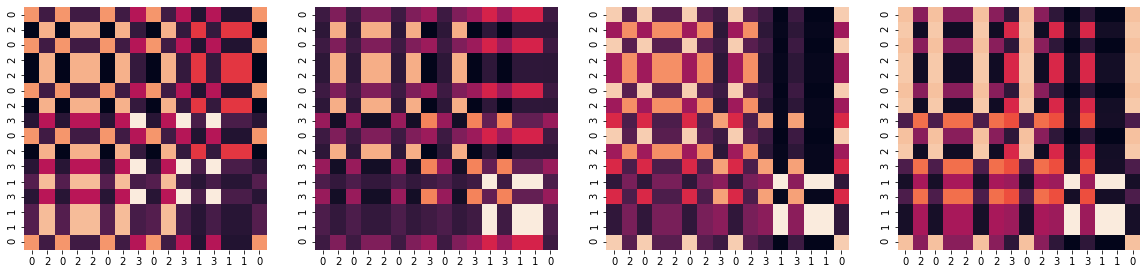

Attention layer  4


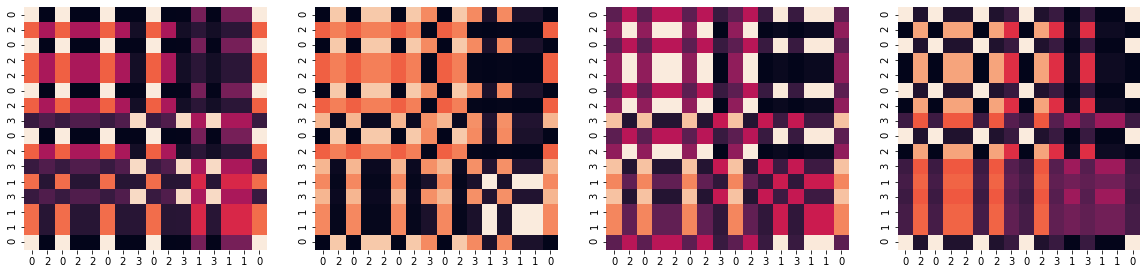

Attention layer  5


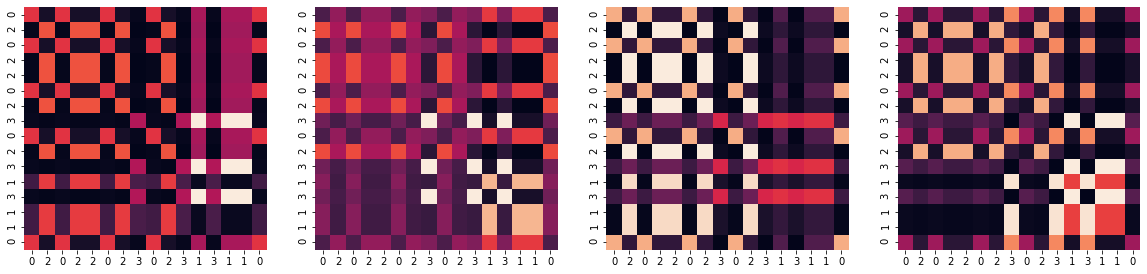

Attention layer  6


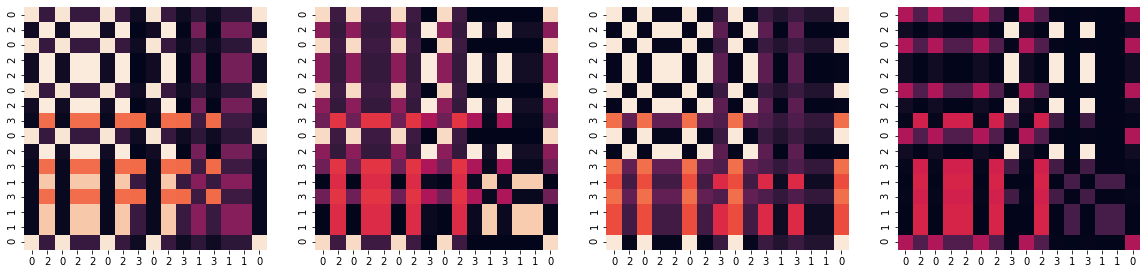

In [238]:
# Attention visualisation with positional encodings removed

model = EncoderModel(vis_n_tokens, HIDDEN_DIM, FF_DIM, OUTPUT_DIM, N_LAYERS, 4, use_positional=False)
_ = train_model(model, LR / 100, NUM_STEPS, BATCH_SIZE, vis_n_tokens, vis_seq_len, vis_test_X, vis_test_Y, print_mismatched=True, get_errs=False)

visualise_attention(model, vis_test_X)